# CSV Log Visualization
This notebook provides functions to load and visualize CSV log files from GMM training.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from typing import List, Dict, Optional, Union

# Set matplotlib to simple, clean style
plt.rcParams.update({
    'font.size': 10,
    'axes.linewidth': 0.8,
    'axes.edgecolor': 'black',
    'xtick.major.width': 0.8,
    'ytick.major.width': 0.8,
    'xtick.major.size': 3,
    'ytick.major.size': 3,
    'grid.linewidth': 0.5,
    'grid.alpha': 0.3,
})

print("Libraries imported successfully!")

Libraries imported successfully!


## Define Color Palettes
Scientific journal color palettes for publication-quality figures

In [3]:
# Define color palettes inspired by Nature, Science, Cell, PNAS
COLOR_PALETTES = {
    'nature': [
        '#E64B35',  # Red
        '#4DBBD5',  # Cyan
        '#00A087',  # Teal
        '#3C5488',  # Blue
        '#F39B7F',  # Salmon
        '#8491B4',  # Purple-blue
        '#91D1C2',  # Mint
        '#DC0000',  # Crimson
        '#7E6148',  # Brown
        '#B09C85',  # Tan
    ],
    'science': [
        '#3B4992',  # Deep blue
        '#EE0000',  # Red
        '#008B45',  # Green
        '#631879',  # Purple
        '#008280',  # Teal
        '#BB0021',  # Crimson
        '#5F559B',  # Violet
        '#A20056',  # Magenta
        '#808180',  # Gray
        '#1B1919',  # Black
    ],
    'cell': [
        '#1F77B4',  # Blue
        '#FF7F0E',  # Orange
        '#2CA02C',  # Green
        '#D62728',  # Red
        '#9467BD',  # Purple
        '#8C564B',  # Brown
        '#E377C2',  # Pink
        '#7F7F7F',  # Gray
        '#BCBD22',  # Yellow-green
        '#17BECF',  # Cyan
    ],
    'pnas': [
        '#0072B2',  # Blue
        '#D55E00',  # Vermillion
        '#009E73',  # Bluish green
        '#CC79A7',  # Reddish purple
        '#F0E442',  # Yellow
        '#56B4E9',  # Sky blue
        '#E69F00',  # Orange
        '#999999',  # Gray
        '#000000',  # Black
        '#882255',  # Purple
    ]
}

print(f"Color palettes defined: {list(COLOR_PALETTES.keys())}")

Color palettes defined: ['nature', 'science', 'cell', 'pnas']


## Main Plotting Function
Flexible function to plot multiple CSV files with selected columns

In [4]:
def plot_csv_logs(
    csv_files: List[str],
    columns: List[str],
    labels: Optional[List[str]] = None,
    x_column: str = 'epoch',
    palette: str = 'nature',
    figsize: tuple = (12, 8),
    subplot_layout: Optional[tuple] = None,
    title: Optional[str] = None,
    save_path: Optional[str] = None,
    smooth: bool = False,
    smooth_window: int = 5,
    xlim: Optional[tuple] = None,
    ylim: Optional[Dict[str, tuple]] = None,
    log_scale: Optional[List[str]] = None,
    show_grid: bool = True,
    line_width: float = 1.5,
    alpha: float = 1.0,
    fontsize_x: int = 10,
    fontsize_y: int = 10,
    fontsize_title: int = 12,
    ticklabelsize_x: int = 9,
    ticklabelsize_y: int = 9,
    legend_fontsize: int = 9,
    show_legend: bool = True,
    show_xlabel: bool = False,
    show_ylabel: bool = False,
    show_subplot_title: bool = False,
    box_plot: bool = False,
):
    """
    Plot selected columns from multiple CSV files.
    Simple, clean style consistent with statistical journals.
    
    Parameters
    ----------
    csv_files : List[str]
        List of CSV file paths to load and plot
    columns : List[str]
        List of column names to plot
    labels : Optional[List[str]]
        Custom labels for each CSV file. If None, uses filenames.
    x_column : str
        Column name to use for x-axis (default: 'epoch')
    palette : str
        Color palette: 'nature', 'science', 'cell', 'pnas' (default: 'nature')
    figsize : tuple
        Figure size (width, height) in inches
    subplot_layout : Optional[tuple]
        Subplot layout (rows, cols). If None, auto-computed.
    title : Optional[str]
        Overall figure title
    save_path : Optional[str]
        Path to save the figure. If None, won't save.
    smooth : bool
        Whether to apply moving average smoothing
    smooth_window : int
        Window size for moving average smoothing
    xlim : Optional[tuple]
        X-axis limits (min, max)
    ylim : Optional[Dict[str, tuple]]
        Y-axis limits per column, e.g., {'loss': (0, 10)}
    log_scale : Optional[List[str]]
        List of column names to plot with log scale
    show_grid : bool
        Whether to show grid
    line_width : float
        Width of plot lines
    alpha : float
        Transparency of lines (0-1)
    fontsize_x : int
        Font size for x-axis label (default: 10)
    fontsize_y : int
        Font size for y-axis label (default: 10)
    fontsize_title : int
        Font size for subplot titles (default: 12)
    ticklabelsize_x : int
        Font size for x-axis tick labels (default: 9)
    ticklabelsize_y : int
        Font size for y-axis tick labels (default: 9)
    legend_fontsize : int
        Font size for legend text (default: 9)
    show_legend : bool
        Whether to show legend (default: True)
    show_xlabel : bool
        Whether to show x-axis label (default: False)
    show_ylabel : bool
        Whether to show y-axis label (default: False)
    show_subplot_title : bool
        Whether to show subplot titles (default: False)
    box_plot : bool
        Whether to show all four spines (box the plot). If False, only left and bottom spines are shown (default: False)
    
    Returns
    -------
    fig : matplotlib.figure.Figure
        The created figure
    axes : numpy.ndarray or matplotlib.axes.Axes
        The axes objects
    data_frames : List[pd.DataFrame]
        List of loaded DataFrames
    """
    # Load all CSV files
    data_frames = []
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        data_frames.append(df)
        print(f"Loaded: {Path(csv_file).name} - Shape: {df.shape}")
    
    # Generate labels if not provided
    if labels is None:
        labels = [Path(f).stem for f in csv_files]
    
    # Get colors from palette
    colors = COLOR_PALETTES.get(palette, COLOR_PALETTES['nature'])
    
    # Define line styles to combine with colors for better distinction
    line_styles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1)), (0, (5, 2, 1, 2))]
    
    # Determine subplot layout
    n_cols_to_plot = len(columns)
    if subplot_layout is None:
        n_cols = min(3, n_cols_to_plot)  # Max 3 columns
        n_rows = int(np.ceil(n_cols_to_plot / n_cols))
    else:
        n_rows, n_cols = subplot_layout
    
    # Create figure and axes with white background
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize, facecolor='white')
    if n_cols_to_plot == 1:
        axes = np.array([axes])
    axes = axes.flatten() if isinstance(axes, np.ndarray) else [axes]
    
    # Plot each column
    for col_idx, col_name in enumerate(columns):
        ax = axes[col_idx]
        ax.set_facecolor('white')
        
        # Plot each CSV file
        for file_idx, (df, label) in enumerate(zip(data_frames, labels)):
            if col_name not in df.columns:
                print(f"Warning: Column '{col_name}' not found in {csv_files[file_idx]}")
                continue
            
            if x_column not in df.columns:
                print(f"Warning: X-column '{x_column}' not found in {csv_files[file_idx]}")
                continue
            
            x_data = df[x_column].values
            y_data = df[col_name].values
            
            # Select color and line style
            color = colors[file_idx % len(colors)]
            linestyle = line_styles[file_idx % len(line_styles)]
            
            # Apply smoothing if requested
            if smooth and len(y_data) >= smooth_window:
                y_data_smooth = pd.Series(y_data).rolling(
                    window=smooth_window, center=True).mean().values
                # Plot original data with lower alpha
                ax.plot(x_data, y_data, 
                       color=color,
                       linestyle=linestyle,
                       alpha=0.2, linewidth=line_width * 0.5, zorder=1)
                # Plot smoothed data
                ax.plot(x_data, y_data_smooth, 
                       color=color,
                       linestyle=linestyle,
                       label=label, linewidth=line_width, alpha=alpha, zorder=2)
            else:
                ax.plot(x_data, y_data, 
                       color=color,
                       linestyle=linestyle,
                       label=label, linewidth=line_width, alpha=alpha)
        
        # Configure subplot - clean, minimal style
        if show_xlabel:
            ax.set_xlabel(x_column.capitalize(), fontsize=fontsize_x)
        if show_ylabel:
            ax.set_ylabel('NPPR', fontsize=fontsize_y)
        if show_subplot_title:
            ax.set_title(col_name.replace('_', ' ').title(), fontsize=fontsize_title, pad=8)
        
        # Set x-axis limits
        if xlim is not None:
            ax.set_xlim(xlim)
        
        # Set y-axis limits
        if ylim is not None and col_name in ylim:
            ax.set_ylim(ylim[col_name])
        
        # Set log scale if requested
        if log_scale is not None and col_name in log_scale:
            ax.set_yscale('log')
        
        # Add minimal grid (matching viz_gmm.py style)
        if show_grid:
            ax.grid(axis='y', linestyle=':', linewidth=0.6, color='0.6', alpha=0.8)
            ax.set_axisbelow(True)
        
        # Add legend with clean styling and customizable font size
        if show_legend and len(csv_files) > 1:
            legend = ax.legend(loc='best', fontsize=legend_fontsize, framealpha=1.0, 
                             edgecolor='black', fancybox=False)
            legend.get_frame().set_linewidth(0.8)
        
        # Apply spine styling - box or open style
        if box_plot:
            # Show all four spines (boxed plot)
            for spine in ("top", "right", "bottom", "left"):
                ax.spines[spine].set_visible(True)
                ax.spines[spine].set_linewidth(0.8)
                ax.spines[spine].set_color("0.0")
        else:
            # Open style: hide top and right spines
            for spine in ("top", "right"):
                ax.spines[spine].set_visible(False)
            for spine in ("left", "bottom"):
                ax.spines[spine].set_linewidth(0.8)
                ax.spines[spine].set_color("0.0")
        
        # Tick styling with separate control for x and y tick label sizes
        ax.tick_params(axis='x', which='both', length=3, width=0.8, 
                      color='0.0', labelsize=ticklabelsize_x)
        ax.tick_params(axis='y', which='both', length=3, width=0.8, 
                      color='0.0', labelsize=ticklabelsize_y)
    
    # Hide unused subplots
    for idx in range(n_cols_to_plot, len(axes)):
        axes[idx].set_visible(False)
    
    # Add overall title with minimal styling
    if title is not None:
        fig.suptitle(title, fontsize=12, y=0.98)
    
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path is not None:
        plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
        print(f"\nFigure saved to: {save_path}")
    
    plt.show()
    
    return fig, axes, data_frames

print("Function 'plot_csv_logs' defined successfully!")

Function 'plot_csv_logs' defined successfully!


## Helper Function: Quick Column Inspection

In [5]:
def inspect_csv_columns(csv_files: List[str]):
    """
    Inspect and display columns available in CSV files.
    
    Parameters
    ----------
    csv_files : List[str]
        List of CSV file paths to inspect
    """
    print("="*80)
    print("CSV File Column Inspection")
    print("="*80)
    
    for csv_file in csv_files:
        df = pd.read_csv(csv_file)
        print(f"\nFile: {Path(csv_file).name}")
        print(f"  Shape: {df.shape} (rows, columns)")
        print(f"  Columns: {list(df.columns)}")
        print(f"  First few rows:")
        print(df.head(3).to_string(index=False))
        print("-" * 80)

print("Function 'inspect_csv_columns' defined successfully!")

Function 'inspect_csv_columns' defined successfully!


## Example Usage 1: Inspect CSV Files

In [6]:
# Define CSV files to analyze
# Get all CSV files from the directory using pathlib
csv_dir = Path('./ckp/gmm_ckp/resnet18_on_cifar10')
all_csv_files = sorted([str(f) for f in csv_dir.glob('*.csv')])

print(f"Found {len(all_csv_files)} CSV files in {csv_dir}")

# Inspect first few files
if all_csv_files:
    inspect_csv_columns(all_csv_files[:3])

Found 108 CSV files in ckp/gmm_ckp/resnet18_on_cifar10
CSV File Column Inspection

File: collapse_log_K12_cond(none)_decoder(none)_l2(1)_reg(none).csv
  Shape: (20, 8) (rows, columns)
  Columns: ['epoch', 'max_pi', 'min_pi', 'std_pi', 'entropy_ratio', 'T_pi', 'T_gumbel', 'avg_loss']
  First few rows:
 epoch   max_pi   min_pi   std_pi  entropy_ratio  T_pi  T_gumbel  avg_loss
    10 0.999809 0.000005 0.288615       0.000898   2.6  0.959296  6.854439
    20 0.999942 0.000002 0.288657       0.000305   2.2  0.914070  6.854276
    30 0.999953 0.000002 0.288660       0.000250   1.8  0.868844  6.853552
--------------------------------------------------------------------------------

File: collapse_log_K12_cond(none)_decoder(none)_l2(1)_reg(pi_0p5).csv
  Shape: (20, 8) (rows, columns)
  Columns: ['epoch', 'max_pi', 'min_pi', 'std_pi', 'entropy_ratio', 'T_pi', 'T_gumbel', 'avg_loss']
  First few rows:
 epoch   max_pi   min_pi   std_pi  entropy_ratio  T_pi  T_gumbel  avg_loss
    10 0.085189 0.08

## Example Usage 2: Plot Selected Columns from Multiple Files

Loaded: loss_hist_K7_cond(none)_decoder(trainable_128)_linf(16)_reg(none).csv - Shape: (200, 6)
Loaded: loss_hist_K7_cond(y)_decoder(trainable_128)_linf(16)_reg(none).csv - Shape: (200, 6)
Loaded: loss_hist_K7_cond(x)_decoder(trainable_128)_linf(16)_reg(none).csv - Shape: (200, 6)
Loaded: loss_hist_K7_cond(xy)_decoder(trainable_128)_linf(16)_reg(none).csv - Shape: (200, 6)

Figure saved to: ./log/plots/cond_pr.png


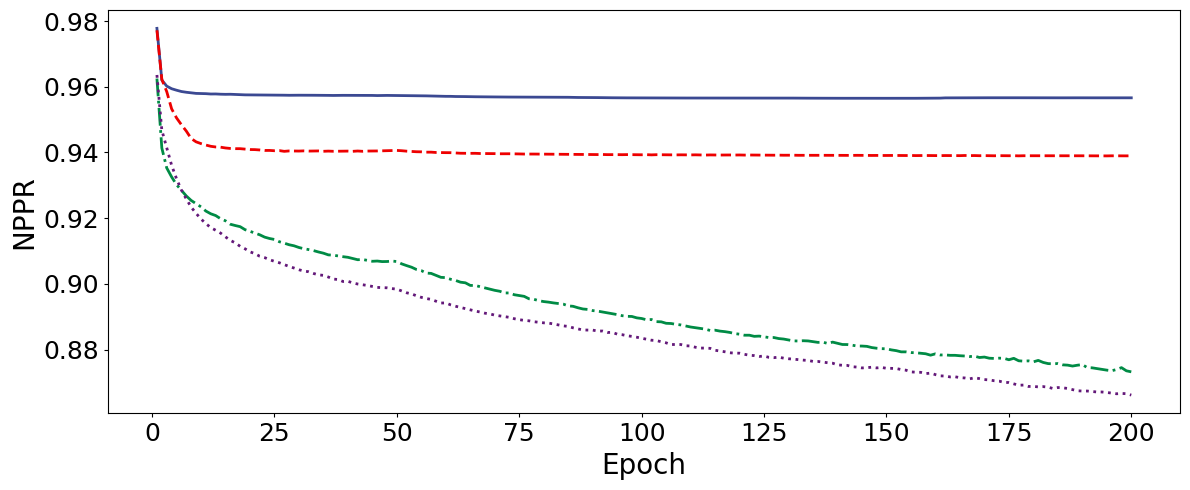

In [58]:
# Select specific CSV files to compare

file_type = 'loss_hist'  # or 'collapse_log'

if file_type == 'collapse_log':
    save_path = './log/plots/cond_entropy_ratio.png'
    columns_to_plot = ['entropy_ratio']
elif file_type == 'loss_hist':
    save_path = './log/plots/cond_pr.png'
    columns_to_plot = ['pr']


selected_csv_files = [
    f'./ckp/gmm_ckp/resnet18_on_cifar10/{file_type}_K7_cond(none)_decoder(trainable_128)_linf(16)_reg(none).csv',
    f'./ckp/gmm_ckp/resnet18_on_cifar10/{file_type}_K7_cond(y)_decoder(trainable_128)_linf(16)_reg(none).csv',
    f'./ckp/gmm_ckp/resnet18_on_cifar10/{file_type}_K7_cond(x)_decoder(trainable_128)_linf(16)_reg(none).csv',
    f'./ckp/gmm_ckp/resnet18_on_cifar10/{file_type}_K7_cond(xy)_decoder(trainable_128)_linf(16)_reg(none).csv'
]


# Custom labels for legend
custom_labels = [
    'Independent',
    'Condition: y',
    'Condition: x',
    'Condition: x and y',
]

# Example: Plot loss with log scale and custom y-limits
fig, axes, dfs = plot_csv_logs(
    csv_files=selected_csv_files,
    columns=columns_to_plot,
    labels=custom_labels,
    x_column='epoch',
    palette='science',
    figsize=(12, 5),
    # subplot_layout=(1, 2),
    # title='Loss',
    log_scale=['main_loss'],  # Use log scale for loss
    # ylim={'main_loss': (0, 1)},  # Set y-limits for main_loss
    # xlim=(0, 100),  # Limit x-axis to first 100 epochs
    smooth=False,
    save_path=save_path,
    line_width=2,
    show_grid=False,
    fontsize_x=20,
    fontsize_y=20,
    ticklabelsize_x=18,
    ticklabelsize_y=18,
    legend_fontsize= 18,
    show_legend= False,
    box_plot = True,
    show_xlabel=True,
    show_ylabel=True
)